In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pybullet as p 
if torch.cuda.is_available() and False:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

%matplotlib notebook

Running on the CPU


Using backend: pytorch


In [2]:
class NetworkInverseDynamics(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        with_batch_norm=False,
        activation=None
    ):
        super(NetworkInverseDynamics, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out


In [3]:
class GNNInverseDynamics(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(GNNInverseDynamics, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.mean('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = output.squeeze(-1).mean(0)
                
        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData


In [4]:
class NetworkAutoEncoder(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size=256, # Needed only for batch norm
        with_batch_norm=False,
        activation=None
    ):
        super(NetworkAutoEncoder, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
#             self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
#                 self.layers.append(nn.BatchNorm1d(batch_size))
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [5]:
class GraphNeuralNetworkAutoEncoder(nn.Module):
    def __init__(
            self,
            inputNetwork,
            messageNetwork,
            updateNetwork,
            outputNetwork,
            numMessagePassingIterations,
            encoder=True
    ):

        super(GraphNeuralNetworkAutoEncoder, self).__init__()

        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork

        self.numMessagePassingIterations = numMessagePassingIterations
        self.encoder = encoder

    def inputFunction(self, nodes):
        return {'state': self.inputNetwork(nodes.data['input'])}

    def messageFunction(self, edges):

        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']

        #         print(edges.src['state'].shape)
        #         print(nodeInput.shape)
        return {'m': self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}

    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}

    def outputFunction(self, nodes):

        #         numNodes, batchSize, stateSize = graph.ndata['state'].shape
        #         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}

    def forward(self, graph, state):

        self.update_states_in_graph(graph, state)

        graph.apply_nodes(self.inputFunction)

        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)

        graph.apply_nodes(self.outputFunction)

        output = graph.ndata['output']

        if self.encoder:
            output = F.normalize(output, dim=-1)

        return output

    def update_states_in_graph(self, graph, state):

        if self.encoder:
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

            numGraphFeature = 6
            numGlobalStateInformation = 5
            numLocalStateInformation = 2
            numStateVar = state.shape[1]
            globalInformation = state[:, 0:5]
            batch_size = state.shape[0]
            numNodes = (numStateVar - 5) // 2

            nodeData = torch.empty(
                (numNodes, batch_size, numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(
                device)

            nodeData[:, :, 0:numGlobalStateInformation] = globalInformation
            for nodeIdx in range(numNodes):
                # Assign local state information
                nodeData[nodeIdx, :, numGlobalStateInformation] = state[:, 5 + nodeIdx]
                nodeData[nodeIdx, :, numGlobalStateInformation + 1] = state[:, 5 + numNodes + nodeIdx]
                # Assign global features from graph
                nodeData[nodeIdx, :, numGlobalStateInformation + 2: numGlobalStateInformation + 2 + numGraphFeature] = \
                graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData

        else:
            numNodes, batchSize, inputSize = state.shape
            nodeData = torch.empty((numNodes, batchSize, inputSize + 6)).to(device)
            nodeData[:, :, :inputSize] = state
            nodeData[:, :, inputSize: inputSize + 6] = graph.ndata['feature'].unsqueeze(dim=1).repeat_interleave(
                batchSize, dim=1)
            #             for nodeIdx in range(numNodes):
            #                 nodeData[nodeIdx, :, inputSize : inputSize + 6] = graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData

In [6]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(5):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None


In [7]:
hidden_sizes = [256, 256]

inputSize = 13
stateSize = 64
messageSize = 64
latentSize = 2
numMessagePassingIterations = 4
batch_size = 1024
numBatchesPerTrainingStep = 1
minRandomDistance = 1
maxSequentialDistance = 0.04
with_batch_norm = True

# # Encoder Networks
encoderInputNetwork = NetworkAutoEncoder(inputSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderMessageNetwork = NetworkAutoEncoder(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderUpdateNetwork = NetworkAutoEncoder(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderOutputNetwork = NetworkAutoEncoder(stateSize, latentSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderGNN = GraphNeuralNetworkAutoEncoder(encoderInputNetwork, encoderMessageNetwork, encoderUpdateNetwork, encoderOutputNetwork, numMessagePassingIterations, encoder=True).to(device)

# # Decoder Networks
decoderInputNetwork = NetworkAutoEncoder(latentSize + 6, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderMessageNetwork = NetworkAutoEncoder(stateSize + latentSize + 7, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
decoderUpdateNetwork = NetworkAutoEncoder(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderOutputNetwork = NetworkAutoEncoder(stateSize, 7, hidden_sizes, with_batch_norm=with_batch_norm)
decoderGNN = GraphNeuralNetworkAutoEncoder(decoderInputNetwork, decoderMessageNetwork, decoderUpdateNetwork, decoderOutputNetwork, numMessagePassingIterations, encoder=False).to(device)


print(encoderGNN.load_state_dict(torch.load('../models/GNN-AutoEncoder/multi-GNN-2-latent-contrastive/encoderGNN.pt')))
print(decoderGNN.load_state_dict(torch.load('../models/GNN-AutoEncoder/multi-GNN-2-latent-contrastive/decoderGNN.pt')))

# Optimizer
lr =  1e-5
optimizer = optim.Adam(itertools.chain(
                    encoderInputNetwork.parameters(), encoderMessageNetwork.parameters(), 
                    encoderUpdateNetwork.parameters(), encoderOutputNetwork.parameters(),
                    decoderInputNetwork.parameters(), decoderMessageNetwork.parameters(), 
                    decoderUpdateNetwork.parameters(), decoderOutputNetwork.parameters()),
                    lr, weight_decay=0)

lr_lambda = lambda epoch: 0.7
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda)
criterion  = nn.MSELoss(reduction='none')

<All keys matched successfully>
<All keys matched successfully>


In [8]:
hidden_sizes = [256, 256]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
numMessagePassingIterations = 6
batch_size = 2048
with_batch_norm = True
numBatchesPerTrainingStep = 1

inputNetwork = NetworkInverseDynamics(inputSize, stateSize, hidden_sizes, with_batch_norm)
messageNetwork = NetworkInverseDynamics(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm, nn.Tanh)
updateNetwork = NetworkInverseDynamics(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm)
outputNetwork = NetworkInverseDynamics(stateSize, outputSize, hidden_sizes, with_batch_norm, nn.Sigmoid)

inverseDynamics = GNNInverseDynamics(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations)
inverseDynamics.load_state_dict(torch.load('mixed-delta-validTransition.pt'))

<All keys matched successfully>

In [10]:
morphIdx = 3
max_vel = states[morphIdx][:, 0].max()
min_vel = states[morphIdx][:, 0].min()
num_samples = 1000
state_space = states[morphIdx][0].shape[0]
# offsets = torch.from_numpy(np.linspace(start=min_vel, stop=max_vel, num=num_samples))
# offsets = torch.from_numpy(np.linspace(start=-2, stop=2, num=num_samples))
offsets = torch.from_numpy(np.random.normal(size=(num_samples, state_space)))
randomly_sampled_state = torch.from_numpy(states[morphIdx][0][np.newaxis, ...].repeat(repeats=num_samples, axis=0)).repeat(1,2)
randomly_sampled_state[:, state_space:] = offsets

In [11]:
g = env[morphIdx].get_graph()._get_dgl_graph().to('cpu')
predicted_sigmoids = inverseDynamics(g, randomly_sampled_state)

In [12]:
predicted_sigmoids

tensor([2.6832e-04, 3.0714e-04, 7.2777e-02, 2.7398e-04, 2.8954e-04, 2.6694e-04,
        2.7123e-04, 3.1174e-04, 5.8082e-04, 2.8513e-04, 2.8788e-04, 2.8134e-04,
        3.0874e-04, 2.7454e-04, 2.8127e-04, 2.8659e-04, 2.8869e-04, 2.6623e-04,
        2.7331e-04, 2.7376e-04, 3.9366e-04, 3.2094e-04, 7.2367e-04, 6.4372e-03,
        3.8639e-04, 3.0085e-04, 2.7100e-04, 4.2751e-04, 2.6139e-04, 2.6940e-04,
        2.9398e-04, 2.9013e-04, 2.7273e-04, 2.6363e-04, 3.1782e-04, 2.5675e-04,
        3.8016e-04, 4.2319e-04, 2.5751e-04, 3.1507e-04, 3.9331e-04, 2.7653e-04,
        2.7560e-04, 2.7304e-04, 2.6361e-04, 2.6362e-04, 2.8495e-04, 2.6511e-04,
        2.9052e-04, 5.1513e-04, 2.6244e-04, 2.7968e-04, 3.4320e-04, 3.7409e-04,
        3.9431e-04, 4.5396e-02, 2.6479e-04, 3.5612e-04, 2.8553e-04, 3.1036e-04,
        3.1028e-04, 2.6332e-04, 2.5217e-04, 3.1616e-04, 3.3119e-04, 2.9999e-04,
        2.7787e-04, 2.6626e-04, 2.7524e-04, 4.9308e-04, 2.6466e-04, 2.6051e-04,
        2.8435e-04, 2.6735e-04, 2.6384e-

In [23]:
shiftAmount = 1


for morphIdx in range(0):
    
    with torch.no_grad():
        
        numEpisodesToAverage = 1
        normalized_latent_states = None
        for episodeNumber in range(numEpisodesToAverage):
            
            g = env[morphIdx].get_graph()._get_dgl_graph().to(device)
            if normalized_latent_states is None:
                latentEncodings = encoderGNN(g, torch.from_numpy(states[morphIdx][500 * numEpisodesToAverage: 500 * (numEpisodesToAverage+1)])) / numEpisodesToAverage
                normalized_latent_states = latentEncodings / torch.sqrt((latentEncodings ** 2).sum(dim=1)).unsqueeze(1)

            else:
                latentEncodings = encoderGNN(g, torch.from_numpy(states[morphIdx][500 * numEpisodesToAverage: 500 * (numEpisodesToAverage+1)])) / numEpisodesToAverage
                normalized_latent_states += latentEncodings / torch.sqrt((latentEncodings ** 2).sum(dim=1)).unsqueeze(1)

    
    latentEncodings = latentEncodings.to('cpu')
    numNodes, batchSize, latentSize = latentEncodings.shape
    fig = plt.figure() 
    z = np.arange(batchSize) 
    # syntax for 3-D projection 
    ax = plt.axes(projection ='3d') 

    
    for nodeIdx in range(numNodes):
        
        xy_shift = (- numNodes / 2 + nodeIdx) * shiftAmount
        # defining all 3 axes 
        x = np.array(latentEncodings[nodeIdx, :, 0]) + xy_shift
        y = np.array(latentEncodings[nodeIdx, :, 1]) + xy_shift

        # plotting 
        ax.scatter3D(x, y, z, alpha=0.7)
    ax.set_xlabel('Latent Variable 0 (Shifted)')
    ax.set_ylabel('Latent Variable 1 (Shifted)')
    ax.set_zlabel('Episode Step')
    ax.set_title('Latent Space Variables over Episode Step for all Nodes')
    ax.legend(['Node ' + str(x) for x in range(numNodes)])

    ax.view_init(elev=0, azim=45)
    fig.savefig('{}-latentVis-1.png'.format(morphIdx))

    ax.view_init(elev=30, azim=90)
    fig.savefig('{}-latentVis-2.png'.format(morphIdx))
    
    
    ax.view_init(elev=15, azim=0)
    fig.savefig('{}-latentVis-3.png'.format(morphIdx))

    ax.view_init(elev=90, azim=0)
    fig.savefig('{}-latentVis-4.png'.format(morphIdx))

    plt.show()

In [16]:
# Start of 'valid transition probability' visualization

In [13]:
def reconstructStateFromGraph(graph_data):
    num_nodes, batch_size, data_size = graph_data.shape
    output = torch.empty((batch_size, 5 + 2 * num_nodes))
    output[:, :5] = graph_data[:, :, :5].mean(dim=0)
    output[:, 5::2] = graph_data[:, :, 5].T
    output[:, 6::2] = graph_data[:, :, 6].T
    
    return output

In [29]:
num_samples = 8096

morphIdx = 3
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
num_nodes = g.num_nodes()

next_states_encodings = torch.empty((num_nodes, num_samples, 2))
xs = torch.from_numpy(np.linspace(-1, 1, num=num_samples // 2)[np.newaxis, ...], ).to(torch.float32).repeat(num_nodes, 1)
ys = torch.sqrt(1 - xs ** 2)
next_states_encodings[:, : num_samples // 2, 0] = xs
next_states_encodings[:, num_samples // 2 : , 0] = xs
next_states_encodings[:, :num_samples // 2 , 1] = ys
next_states_encodings[:, num_samples // 2: , 1] = -ys

In [ ]:
next_states = decoderGNN(g, next_states_encodings).to('cpu').detach()
next_states = reconstructStateFromGraph(next_states)

In [23]:
random_idx = 123
state_size = next_states.shape[1]
uniformly_sampled_states = next_states[random_idx].repeat(num_samples, 2)
uniformly_sampled_states[:, state_size:] -= next_states
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
uniformly_sampled_sigmoids = inverseDynamics(g, uniformly_sampled_states)

num_velocity_samples = 1024
velocity_changed_states = torch.zeros(num_velocity_samples, state_size * 2)
velocity_changed_states[:, :state_size] = next_states[random_idx].repeat(num_velocity_samples, 1)
velocity_changed_states[:, state_size] = torch.from_numpy(np.linspace(start=-0.1, stop=3, num=num_velocity_samples))
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
velocity_changed_sigmoids = inverseDynamics(g, velocity_changed_states)
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
velocity_changed_encodings = encoderGNN(g, velocity_changed_states[:, state_size:])

In [24]:
print(velocity_changed_sigmoids.mean())
print(velocity_changed_sigmoids.min())
print(velocity_changed_sigmoids.max())
print(velocity_changed_sigmoids.std())

tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MinBackward1>)
tensor(0.0048, grad_fn=<MaxBackward1>)
tensor(0.0011, grad_fn=<StdBackward>)


In [25]:
state_space = states[morphIdx][0].shape[0]
offsets = torch.from_numpy(np.random.normal(size=(num_samples, state_space)))

In [26]:
x = next_states_encodings[0, :, 0].numpy()
y = next_states_encodings[0, :, 1].numpy()
c = uniformly_sampled_sigmoids.cpu().detach().numpy()

<IPython.core.display.Javascript object>


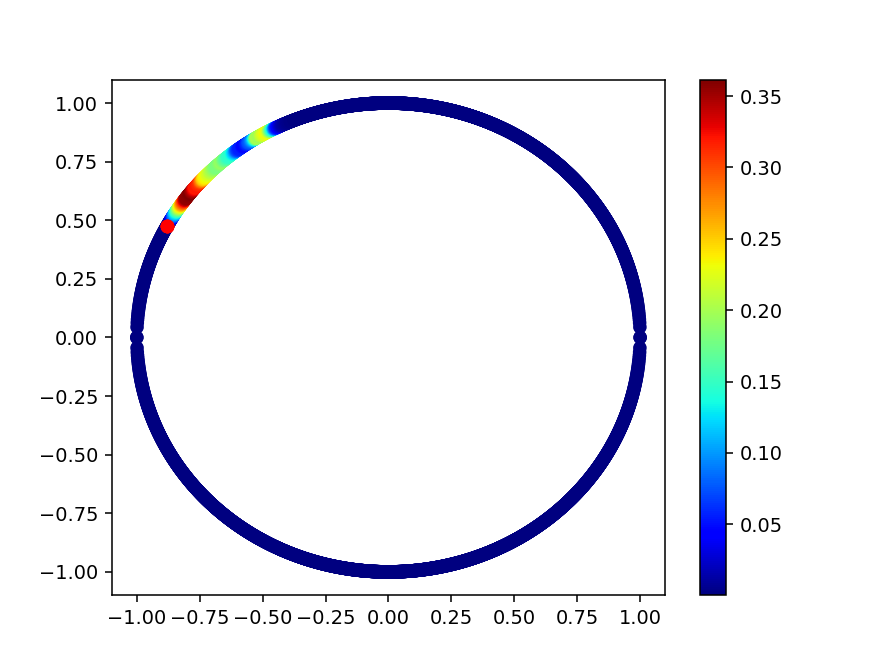

In [28]:
cmap = 'jet'

plt.scatter(x, y, c=c, cmap=cmap)
plt.scatter(next_states_encodings[:, random_idx, 0], next_states_encodings[:, random_idx, 1], c='red')

normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(c)
plt.colorbar(scalarmappaple)

plt.show()
plt.savefig('transition-prob-vis.png')

In [25]:
g = env[morphIdx].get_graph()._get_dgl_graph()
encodings = encoderGNN(g, randomly_sampled_state).to('cpu').detach().numpy()

shiftAmount = 1

numNodes, batchSize, latentSize = encodings.shape
fig = plt.figure() 
z = np.linspace(start=min_vel, stop=max_vel, num=num_samples)
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 


for nodeIdx in range(numNodes):

    xy_shift = (- numNodes / 2 + nodeIdx) * shiftAmount
    # defining all 3 axes 
    x = np.array(encodings[nodeIdx, :, 0]) + xy_shift
    y = np.array(encodings[nodeIdx, :, 1]) + xy_shift

    # plotting 
    ax.scatter3D(x, y, z, alpha=0.7)
    
ax.set_xlabel('Latent Variable 0 (Shifted)')
ax.set_ylabel('Latent Variable 1 (Shifted)')
ax.set_zlabel('X Velocity')
ax.set_title('Latent Space Variables over Episode Step for all Nodes')
ax.legend(['Node ' + str(x) for x in range(numNodes)])

ax.view_init(elev=0, azim=45)
fig.savefig('{}-latentVis-1.png'.format(morphIdx))

ax.view_init(elev=30, azim=90)
fig.savefig('{}-latentVis-2.png'.format(morphIdx))


ax.view_init(elev=15, azim=0)
fig.savefig('{}-latentVis-3.png'.format(morphIdx))

ax.view_init(elev=90, azim=0)
fig.savefig('{}-latentVis-4.png'.format(morphIdx))

plt.show()

IndexError: index 5 is out of bounds for dimension 0 with size 5